In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from files.Simulation import Simulation
from files.Source import Source
from files.Observer import Observer
from files.Propagator import Propagator
from files.Observer import TimeEvolutionObserverLog
from plot.Trajectory import Trajectory
from plot.Statistics import Statistics

## Simulation setup

#### Simulation setup

In [2]:
dimensions = 3
sim = Simulation()

start simulation


#### Source 

In [3]:
nr_particles = 1*10**2
source_pos = np.array([1.0, 1.0, 1.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]; 1pc

source = Source(gyro_radius, source_pos, nr_particles, dimensions)
sim.add_source(source)

Source initialized


#### Propagator

In [4]:
nr_steps = 2*10**5
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]

propagator = Propagator(nr_steps, step_size, mfp)
propagator.get_description()
sim.add_propagator(propagator)

Propagator initialized
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

coordinates: Cylindrical coordinates
dimensions:  3
pitch angle: constant
particle speed:  299800000.0  m/s
number steps:  200000
step size:  5000000000.0  m
step duration:  16.677785873413086  s
total distance:  1000000000000000.0  m
total duration:  3335557.0380253503  s
probability to change directions in step:  [0.23474179 0.23474179 0.11860708] %


#### Observer

In [5]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
sim.add_observer(observer)

number steps:  169
Observer initialized


In [6]:
%time sim.run_simulation()
sim.save_data('data')

init source
CPU times: user 30.5 s, sys: 11.1 ms, total: 30.5 s
Wall time: 30.5 s


## Analyze statistics


init statistics plotting class


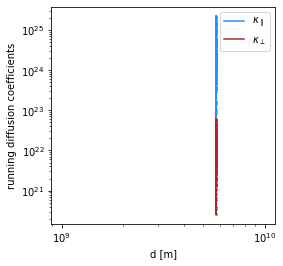

In [7]:
df = pd.read_pickle("data.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
dimensions = 3
sta = Statistics(df_time_evolution_observer, dimensions)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

In [8]:
rwp_d = df_kappas['d'].tolist()
rwp_kappa_perp = df_kappas['kappa_perp'].tolist()
rwp_kappa_para = df_kappas['kappa_para'].tolist()

In [26]:
### load crpropa data
crp_d = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_d.npy')
crp_kappa_perp = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_kappa_perp.npy')
crp_kappa_para = np.load('data/E_3e+16_bB_0.5_seeds_50_149_nr_20_kappa_para.npy')

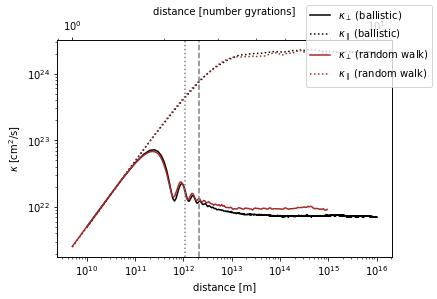

In [27]:
fig, ax1 = plt.subplots()

ax1.plot(crp_d, np.array(crp_kappa_perp)*10**4, label='$\kappa_\perp$ (ballistic)', color='k')
ax1.plot(crp_d, np.array(crp_kappa_para)*10**4, linestyle=':', label='$\kappa_\parallel$ (ballistic)', color='k')
ax1.plot(rwp_d, np.array(rwp_kappa_perp)*10**4, label='$\kappa_\perp$ (random walk)', color='brown')
ax1.plot(rwp_d, np.array(rwp_kappa_para)*10**4, linestyle=':', label='$\kappa_\parallel$ (random walk)', color='brown')

ax1.set_xlabel('distance [m]')
ax1.axvline(x=mfp[1], c='grey', ls=':')
ax1.axvline(x=mfp[2], c='grey', ls='--')
ax1.loglog()
ax1.set_ylabel('$\kappa$ [cm$^2$/s]')

ax2 = ax1.twiny()
#ax2.scatter(np.array([rwp_d[0], rwp_d[-1]]) / (2 * np.pi * gyro_radius), np.ones(2)*kappa_perp_mean*10**4, s=0.0001)
ax2.set_xlabel('distance [number gyrations]')
ax2.loglog()

fig.legend()
plt.show()
#plt.savefig('kappas_bB05.pdf')